# Анализ влияния источника перехода в игру на поведение пользователя в мобильной игре

**Задачи**:
- *предобработка данных*
- *исследовательский анализ*:
- посчитать, какой % пользователей завершил 1 уровень (в разбивке на источники)
- посмотреть, какая часть пользователей завершает уровень, выполнив 1-е условие, а какая - выполнив 2-е условие (в целом и в разбивке на источники)
- в зависимости от выполненного условия изучить, какие действия совершают игроки (сколько зданий строят, какие здания строят)
- сколько времени уходит на завершение уровня (в зависимости от условия и в разбивке на источники)
- *статистический анализ, проверка гипотез*


# Оглавление
1. [Предобработка данных](#предобработка)  
2. [Исследовательский анализ](#анализ)  
3. [Проверка гипотез](#гипотезы)  
4. [Общий вывод](#вывод)  


In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

# 1. Предобработка данных <a name="предобработка"></a>

In [2]:
# считываем имеющиеся датафреймы
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

In [3]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


В таблице ***game_actions*** имеются столбцы:
- event_datetime (дата совершения события)
- event (название события)
- building_type (тип постройки)
- user_id (id пользователя)
- project_type (тип проекта)

In [4]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


Есть пропуски в столбцах ***"тип постройки*** и ***"тип проекта"***. Скорее всего, в типе постройки пропущены значения в событиях, не относящихся к строительству. 
Столбец с датой нужно привести к формату *datetime*

In [5]:
game_actions.event.value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

Проект завершили ***1866*** игороков, а первый уровень - ***5817***

Для завершения первого уровня неоходимо либо выполнить проект по постройке, либо одержать победу над другим игроком. 

In [6]:
game_actions[game_actions.event == 'building'][['event', 'building_type']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127957 entries, 0 to 135637
Data columns (total 2 columns):
event            127957 non-null object
building_type    127957 non-null object
dtypes: object(2)
memory usage: 2.9+ MB


Все верно, тип здания указан только в ячейках событий "строительство"

In [7]:
game_actions.project_type.value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [8]:
# преобразовываем формат даты
game_actions['date'] = pd.to_datetime(game_actions.event_datetime)

In [9]:
#выделяем дату без времени
game_actions['day'] = game_actions.event_datetime.astype('datetime64[D]')

В таблице должны быть данные по когорте с 4 по 10 мая, нужно проверить, так ли это

In [10]:
game_actions.date.agg(['min', 'max'])

min   2020-05-04 00:00:01
max   2020-06-05 12:32:49
Name: date, dtype: datetime64[ns]

Сами события длятся с 4 мая по 5 июня

In [11]:
game_actions.user_id.nunique()

13576

In [12]:
len(game_actions.groupby('user_id')['date'].min() <= '2020-05-10') 

13576

У нас всего 13576 пользователей, все принадлежат когорте с 4 по 10 мая

In [13]:
#проверяем дубликаты
game_actions[game_actions.duplicated(keep = False)]

,event_datetime,event,building_type,user_id,project_type,date,day
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN,2020-05-10 18:41:56,2020-05-10
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN,2020-05-10 18:41:56,2020-05-10


In [14]:
# удаляем найденный дубликат 
game_actions.drop_duplicates(keep='first', inplace = True)
game_actions.reset_index(inplace = True)

In [15]:
game_actions.event.value_counts()

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [16]:
game_actions.event.value_counts()['finished_stage_1'] - game_actions.event.value_counts()['project']

3951

In [17]:
game_actions.project_type.value_counts(dropna = False)

NaN                           133773
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

В столбце событий содержится 3 типа ивентов: 
- постройка
- завершение 1 уровня
- выполнение проекта  
Чтобы завершить 1 уровень нужно либо выполнить проект, либо победить другого игрока. Факт победы над игроком у нас отсутствует. Было принято решение, что пользователи, у которых есть запись о завершении уровня, но нет записи о выполненном проекте, прошли 1 уровень путем выполнения альтернативного условия. Таких пользователей **3951**

In [18]:
#список пользователей, выполнивших проект по постройке орбитальной станции
builders = game_actions.loc[(game_actions.project_type == 'satellite_orbital_assembly')]['user_id']

In [19]:
#заменяем пропуски в project_type для остальных пользователей, завершивших 1 уровень, на 'battle'
game_actions.loc[(game_actions.event == 'finished_stage_1') & (~game_actions.user_id.isin(builders)), 'project_type'] = 'battle'

In [20]:
game_actions.project_type.value_counts(dropna = False)

NaN                           129822
battle                          3951
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

In [21]:
# также отдельно выделим id тех, кто закончил уровень боем
warriors = game_actions.loc[(game_actions.project_type == 'battle')]['user_id']

Каждому юзеру присвоим тип в зависимости от способа завершения уровня

In [22]:
conditions = [(game_actions.user_id.isin(builders)), (game_actions.user_id.isin(warriors)), (~game_actions.user_id.isin(builders)) & (~game_actions.user_id.isin(warriors))]

In [23]:
values = ['builder', 'warrior', 'not_finished']

In [24]:
game_actions['user_type'] = np.select(conditions, values)

In [25]:
game_actions.groupby('user_type')['user_id'].nunique()

user_type
builder         1866
not_finished    7759
warrior         3951
Name: user_id, dtype: int64

пропишем условие, при котором можно считать, что игрок завершил первый уровень

In [26]:
finish_conds = (game_actions.user_type == 'builder') | (game_actions.user_type == 'warrior')

Посмотрим на датафрейм ***ad_costs***

In [27]:
ad_costs.head()


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Здесь содержится информация о затратах на различные источники рекламы:
- source (название источника)
- day (день)
- cost (затраты)

In [28]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [29]:
ad_costs.source.value_counts()

facebook_ads               7
youtube_channel_reklama    7
instagram_new_adverts      7
yandex_direct              7
Name: source, dtype: int64

Всего 4 типа источника

In [30]:
ad_costs.day.agg(['min', 'max'])

min    2020-05-03
max    2020-05-09
Name: day, dtype: object

Данные с 3 по 9 мая. Когорта игроков у нас с 4 по 10 мая, значит факт привлечения идет следующим днем. 

In [31]:
# преобразовываем формат даты
ad_costs['date'] = pd.to_datetime(ad_costs.day)

Для дальнейшего удобства синхронизируем дату затрат на источники и когорту пользователей

In [32]:
ad_costs['shifted_date'] = ad_costs.date + pd.Timedelta(days=1)

In [33]:
ad_costs.shifted_date.agg(['min', 'max'])

min   2020-05-04
max   2020-05-10
Name: shifted_date, dtype: datetime64[ns]

Изучим датафрейм ***user_source***

In [34]:
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Здесь содержится информация о том, какой пользователь из какого источника был привлечен

In [35]:
game_actions.user_id.nunique()

13576

In [36]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


In [37]:
user_source.source.value_counts()

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

Пропусков нет, формат данных корректный

In [38]:
#соединим данные из таблиц "game_actions" и "user_source"
game_actions = game_actions.merge(user_source, how = 'left', on = 'user_id')

In [39]:
game_actions[game_actions.user_id == '55e92310-cb8e-4754-b622-597e124b03de']

,index,event_datetime,event,building_type,user_id,project_type,date,day,user_type,source
0,0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04 00:00:01,2020-05-04,not_finished,youtube_channel_reklama
10101,10101,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05 05:20:15,2020-05-05,not_finished,youtube_channel_reklama
15489,15489,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05 19:24:02,2020-05-05,not_finished,youtube_channel_reklama
16114,16114,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05 20:59:19,2020-05-05,not_finished,youtube_channel_reklama
17607,17607,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06 00:52:56,2020-05-06,not_finished,youtube_channel_reklama
42109,42109,2020-05-08 08:16:51,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-08 08:16:51,2020-05-08,not_finished,youtube_channel_reklama
76039,76040,2020-05-10 20:27:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-10 20:27:01,2020-05-10,not_finished,youtube_channel_reklama


Также добавим столбцы с датой первого события и последнего события для каждого юзера. И посчитаем, сколько времени прошло между этими событиями

In [40]:
first_date = game_actions.groupby(['user_id'])['date'].min()
last_date = game_actions.groupby(['user_id'])['date'].max()
first_date.name = 'first_event_date'
last_date.name = 'last_event_date'
game_actions = game_actions.join(first_date,on='user_id').join(last_date,on='user_id')

Заодно проверим, можно ли считать, что для тех, кто завершил 1 уровень, факт завершения уровня является последним событием

In [41]:
(game_actions[game_actions.event == 'finished_stage_1'].groupby('user_id')['date'].max() != game_actions[game_actions.event == 'finished_stage_1'].groupby('user_id')['last_event_date'].max()).sum()

0

In [42]:
#добавляем столбец с временем, затраченным на игру
game_actions['time_spent'] = ((game_actions['last_event_date'] - game_actions['first_event_date']) / np.timedelta64(1, 'h')).astype('float64').round(2)

# 2. Исследовательский анализ <a name="анализ"></a>

##### Проверим, сколько игроков было привлечено из имеющихся источников

In [43]:
(game_actions.groupby('source')['user_id'].nunique().sort_values(ascending = False) / game_actions['user_id'].nunique() * 100).round(2).reset_index(name = '% привлеченных игроков')

,source,% привлеченных игроков
0,yandex_direct,35.48
1,instagram_new_adverts,24.65
2,facebook_ads,20.08
3,youtube_channel_reklama,19.78


Больше всего пользователей этой когорты пришло из Яндекс Директа, меньше всего - из Ютьюба

##### Посчитаем, сколько пользователей завершили 1 уровень в разбивке на источники

In [44]:
rates = game_actions.groupby(['source', 'event'])['user_id'].nunique().reset_index().merge(game_actions.groupby('source')['user_id'].nunique().reset_index(), how = 'left', on = ['source'])
rates['rate %'] = (rates.user_id_x / rates.user_id_y * 100).round(2)
rates

,source,event,user_id_x,user_id_y,rate %
0,facebook_ads,building,2726,2726,100.00
1,facebook_ads,finished_stage_1,1150,2726,42.19
2,facebook_ads,project,391,2726,14.34
3,instagram_new_adverts,building,3347,3347,100.00
4,instagram_new_adverts,finished_stage_1,1466,3347,43.80
5,instagram_new_adverts,project,476,3347,14.22
6,yandex_direct,building,4817,4817,100.00
7,yandex_direct,finished_stage_1,2042,4817,42.39
8,yandex_direct,project,620,4817,12.87
9,youtube_channel_reklama,building,2686,2686,100.00


In [45]:
#функция для постройки барплотов
def barplt(X, Y, DATA, HUE, TITLE, XLABEL, YLABEL, TXTFRMT):
    # X, Y - данные по осям
    # DATA - датафрейм для графика
    # HUE - параметр для разбиения, если не требуется, то = None
    # TITLE, XLABEL, YLABEL - подписи (название графика, оси х, оси у)
    # TXTFRMT - формат для вывода значения баров
    
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(x = X, y = Y, hue = HUE, data=DATA, ci=None, palette="muted",orient='v')
    ax.set_title(TITLE, fontsize=15)
    ax.set_xlabel (XLABEL, fontsize=15)
    ax.set_ylabel (YLABEL, fontsize=15)
    if TXTFRMT == '%':
        for rect in ax.patches:
            ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), "%.0f%%"% rect.get_height(), weight='bold' )
    if TXTFRMT == 'f':
        for rect in ax.patches:
            ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), "%.0f"% rect.get_height(), weight='bold' )

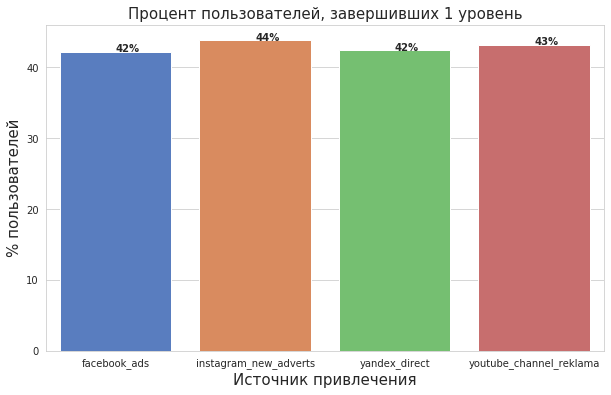

In [46]:
barplt('source', 'rate %',rates[rates.event == 'finished_stage_1'], None, "Процент пользователей, завершивших 1 уровень", "Источник привлечения","% пользователей", '%' )

В целом, % пользователей, завершивших уровень приблизительно одинаков для всех источников - ***42-44%***

##### Посмотрим, какой тип пользователей преобладает (воины или строители)

In [47]:
(game_actions[finish_conds].groupby(['source', 'user_type'])['user_id'].nunique() / game_actions[finish_conds].groupby('source')['user_id'].nunique() * 100).round(2).reset_index(name = 'rate %')

,source,user_type,rate %
0,facebook_ads,builder,34.00
1,facebook_ads,warrior,66.00
2,instagram_new_adverts,builder,32.47
3,instagram_new_adverts,warrior,67.53
4,yandex_direct,builder,30.36
5,yandex_direct,warrior,69.64
6,youtube_channel_reklama,builder,32.70
7,youtube_channel_reklama,warrior,67.30


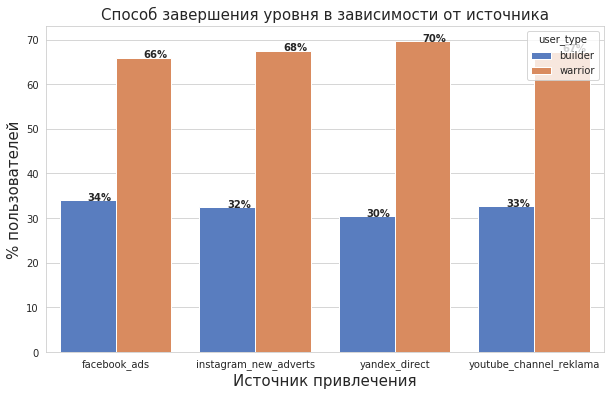

In [48]:
barplt('source', 'rate %', 
       (game_actions[finish_conds].groupby(['source', 'user_type'])['user_id'].nunique() / game_actions[finish_conds].groupby('source')['user_id'].nunique() * 100).round(2).reset_index(name = 'rate %'), 
       'user_type', 
       "Способ завершения уровня в зависимости от источника", 
       "Источник привлечения", 
       "% пользователей", 
       '%')

Типы пользователей тоже не сильно отличаются в зависимости от источника. С каждого источника приходит 30-34% строителей и 66-70% воинов. То есть, привлеченная аудитория на разных платформах примерно одинаковая

##### Посмотрим, какие здания строят игроки

In [49]:
game_actions.building_type.value_counts().reset_index()

,index,building_type
0,spaceport,59325
1,assembly_shop,54494
2,research_center,14137


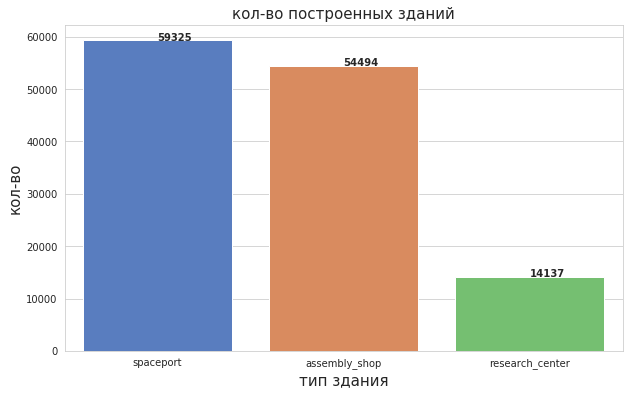

In [50]:
barplt('index', 'building_type', 
       game_actions.building_type.value_counts().reset_index(),
       None,
       'кол-во построенных зданий',
       'тип здания',
       'кол-во',
       'f')

Больше всего строят космические порты и магазины, меньше всего - исследовательские центры. Скорее всего это связанно с игровым процессом и внутриигровыми заданиями

In [51]:
game_actions[game_actions.user_id.isin(builders) & (game_actions.event == 'building')].groupby('user_id')['building_type'].nunique().agg(['min', 'max'])

min    3
max    3
Name: building_type, dtype: int64

Все те, кто завершил первый уровень путем выполнения проекта, построили каждое из зданий

In [52]:
game_actions[game_actions.user_id.isin(builders)].building_type.value_counts()

spaceport          10788
assembly_shop       9116
research_center     3697
Name: building_type, dtype: int64

In [53]:
game_actions[game_actions.user_id.isin(warriors)].building_type.value_counts()

spaceport          17132
assembly_shop      16298
research_center     3755
Name: building_type, dtype: int64

###### Проверим, влияет ли как-то выбранный игровой путь на постройку зданий

In [54]:
df = game_actions.pivot_table(index = ['building_type', 'user_type'], 
                              values = 'user_id', 
                              aggfunc = {'user_id' : ['count', 'nunique']}).rename(columns={'count':'всего', 'nunique' : 'uid'}).reset_index()
df['в среднем'] = df['всего'] / df.uid 
df.head()

,building_type,user_type,всего,uid,в среднем
0,assembly_shop,builder,9116,1866,4.885316
1,assembly_shop,not_finished,29080,7759,3.747906
2,assembly_shop,warrior,16298,3951,4.125032
3,research_center,builder,3697,1866,1.981243
4,research_center,not_finished,6685,3463,1.930407


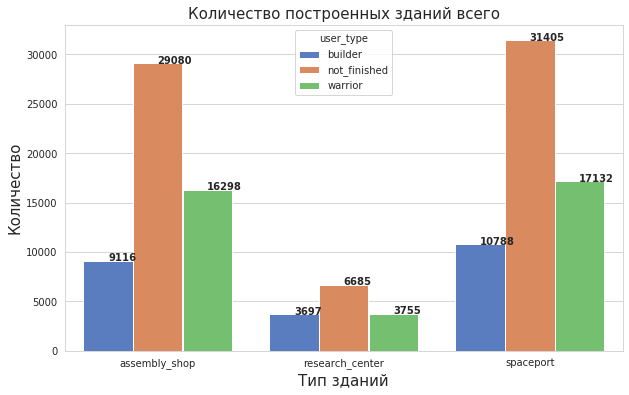

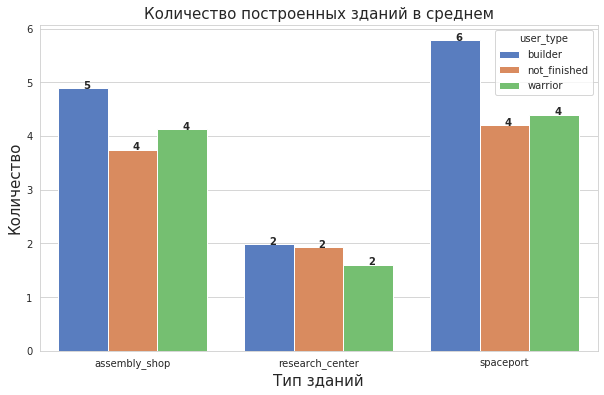

In [55]:
for each in ['всего', 'в среднем']:
    barplt('building_type', each, 
           df,
           'user_type',
           "Количество построенных зданий {}".format(each),
           "Тип зданий",
           "Количество",
           'f')

Очевидно, игроки, завершающие уровень выполнением проекта, строят больше зданий. Основной упор идет на космопорты и магазины

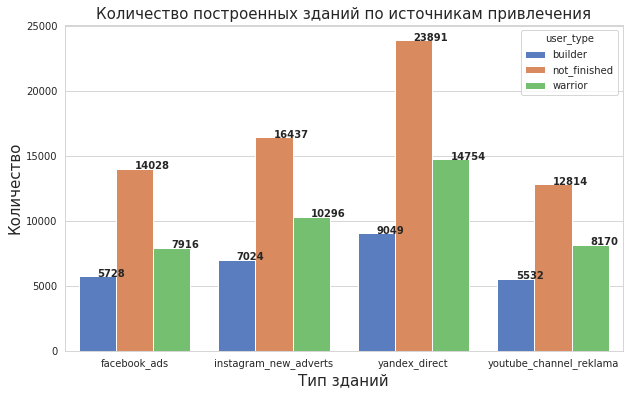

In [56]:
barplt('source', 'всего', 
        game_actions.pivot_table(index = ['source', 'user_type'], 
            values = 'user_id', 
            aggfunc = {'user_id' : 'count'}).rename(columns={'user_id':'всего'}).reset_index(),
        'user_type',
        "Количество построенных зданий по источникам привлечения",
        "Тип зданий",
        "Количество",
        'f')

Для всех источников картина складывается одинаково

Посмотрим на время, затраченное на игру

In [57]:
game_actions.groupby(['user_type', 'user_id'])['time_spent'].max().describe()

count    13576.000000
mean       256.218771
std        104.411245
min          0.000000
25%        184.560000
50%        252.515000
75%        319.485000
max        741.980000
Name: time_spent, dtype: float64

In [58]:
print('В среднем пользователи проводят в игре {:.2f} часов'.format(game_actions.groupby(['user_type', 'user_id'])['time_spent'].max().mean()))

В среднем пользователи проводят в игре 256.22 часов


In [59]:
game_actions[game_actions.user_type == 'not_finished'].groupby('user_id')['time_spent'].max().describe()

count    7759.000000
mean      234.916182
std       104.267020
min         0.000000
25%       159.005000
50%       230.580000
75%       299.250000
max       698.020000
Name: time_spent, dtype: float64

In [60]:
game_actions[finish_conds].groupby('user_id')['time_spent'].max().describe()

count    5817.000000
mean      284.633208
std        97.625838
min         9.650000
25%       221.220000
50%       277.480000
75%       341.250000
max       741.980000
Name: time_spent, dtype: float64

При этом, среднее время, затраченное на игру у тех, кто так и не завершил уровень, не так уж и сильно отличается от завершивших. Нужно подробнее изучить, почему пользователи так и не закончили 1 уровень

In [61]:
def histplt(data, Y, TITLE, XLABEL, YLABEL, ALPHA):
    ax = data.plot(y = Y, kind = 'hist', bins = 20, figsize = (9, 9), title = TITLE, alpha = ALPHA)
    ax.set_xlabel(XLABEL, fontsize = 15)
    ax.set_ylabel(YLABEL, fontsize = 15)
    plt.show()

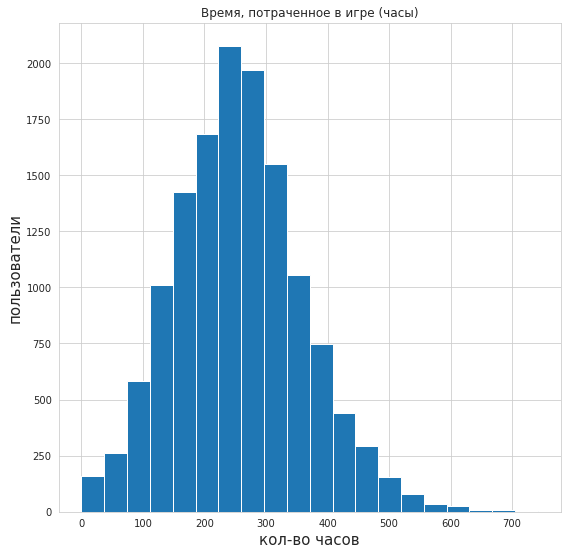

In [62]:
histplt(game_actions.groupby('user_id')['time_spent'].max(), 
        'time_spent', 
        'Время, потраченное в игре (часы)', 
        'кол-во часов', 
        'пользователи',
       1)

Посмотрим, как выглядит это распределение для тех, кто завершил 1 уровень, а так же в разбивке на тип пользователя и источник привлечения

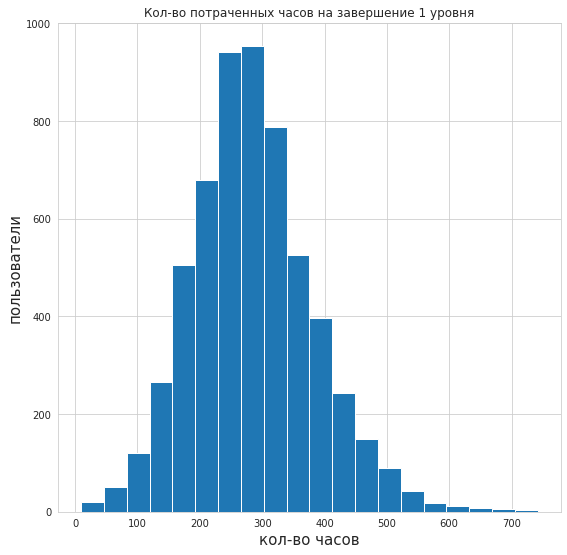

In [63]:
histplt(game_actions[finish_conds].groupby('user_id')['time_spent'].max(), 
        'time_spent', 
        'Кол-во потраченных часов на завершение 1 уровня', 
        'кол-во часов', 
        'пользователи',
       1)

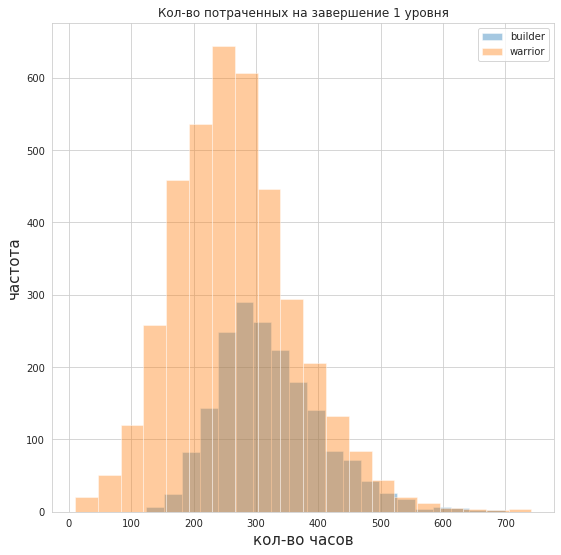

In [64]:
for each in ['builder', 'warrior']:
    time_spent_hist = game_actions[game_actions.user_type == each].groupby('user_id')['time_spent'].max().plot(y = 'time_spent', kind = 'hist', bins = 20, alpha = 0.4, label = each, figsize = (9, 9), title = 'Кол-во потраченных на завершение 1 уровня')
    time_spent_hist.set_xlabel('кол-во часов', fontsize = 15)
    time_spent_hist.set_ylabel('частота', fontsize = 15)
    plt.legend()

В целом, распределения выглядят идентично, единственное отличие - у строителей минимальное время прохождения смещено относительно воинов. Это скорее всего связано с тем, что на постройку зданий требуется определенное кол-во времени

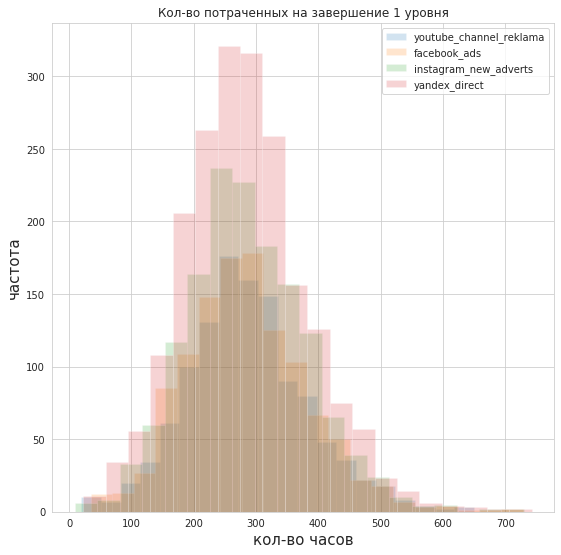

In [65]:
for each in game_actions.source.unique():
    time_spent_hist = game_actions[(finish_conds) & (game_actions.source == each)].groupby('user_id')['time_spent'].max().plot(y = 'time_spent', kind = 'hist', bins = 20, alpha = 0.2, label = each, figsize = (9, 9), title = 'Кол-во потраченных на завершение 1 уровня')
    time_spent_hist.set_xlabel('кол-во часов', fontsize = 15)
    time_spent_hist.set_ylabel('частота', fontsize = 15)
    plt.legend()

Вне зависимости от источника привелечения, пользователи проводят примерно одинковое кол-во времени в игре

##### Посмотрим, сколько было затрачено на привлечение

In [66]:
ad_costs.head()

,source,day,cost,date,shifted_date
0,facebook_ads,2020-05-03,935.882786,2020-05-03,2020-05-04
1,facebook_ads,2020-05-04,548.354480,2020-05-04,2020-05-05
2,facebook_ads,2020-05-05,260.185754,2020-05-05,2020-05-06
3,facebook_ads,2020-05-06,177.982200,2020-05-06,2020-05-07
4,facebook_ads,2020-05-07,111.766796,2020-05-07,2020-05-08


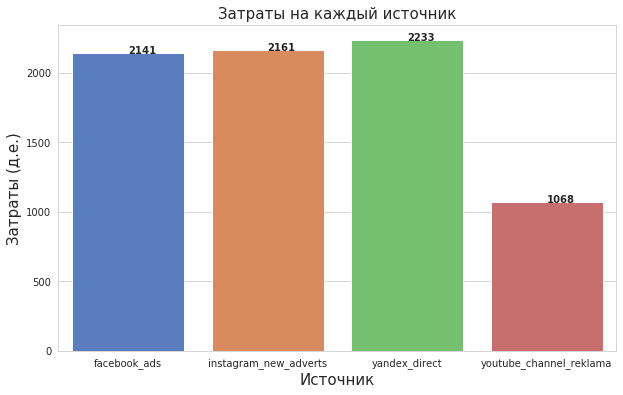

In [67]:
barplt('source', 'cost', 
        ad_costs.groupby('source')['cost'].sum().reset_index(), 
        None,
        "Затраты на каждый источник",
        "Источник",
        "Затраты (д.е.)",
        'f')

Меньше всего было потрачено на Ютьюб. Причем значительно, в 2 раза меньше. Но и пользователей оттуда пришло меньше, чем из других источников. Посмотрим, сколько стоил один привлеченный игрок для каждой платформы

In [68]:
cac = ad_costs.groupby('source').agg({'cost': 'sum'}).reset_index().merge(game_actions.groupby('source')['user_id'].nunique().reset_index(), on = 'source')
cac

,source,cost,user_id
0,facebook_ads,2140.904643,2726
1,instagram_new_adverts,2161.441691,3347
2,yandex_direct,2233.111449,4817
3,youtube_channel_reklama,1068.119204,2686


In [69]:
#проверяем, сходится ли общее кол-во пользователей
cac.user_id.sum()

13576

In [70]:
cac['cac'] = cac['cost'] / cac['user_id']
cac

,source,cost,user_id,cac
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


Text(0, 0.5, 'CAC')

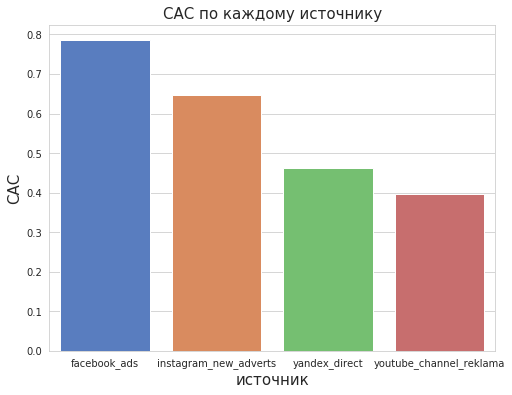

In [71]:
bar,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x = 'source', y = 'cac', data=cac, ci=None, palette="muted",orient='v')
ax.set_title('CAC по каждому источнику', fontsize=15)
ax.set_xlabel ('источник', fontsize=15)
ax.set_ylabel ('CAC', fontsize=15)


Для Ютьюба привлечение оказалось более дешевым в сравнении с другими источниками. Самый дорогой - Фейсбук, в 2 раза дороже Ютьюба

Проведенный анализ показывает, что поведение пользователей не сильно отличается от источника, из которого они пришли в игру. Деление на воинов и строителей примерно одинаково, кол-во построенных зданий - тоже. Распределение времени, затраченного на игру тоже совпадает. Основное отличие - кол-во зданий, которое возводят в процессе игры пользователи, выбирающие стратегию строительство, больше, чем у "воинов". При этом затраты на привлечение сильно отличаются. Поэтому, выгоднее больше делать упор на тот источник, где привлечение 1 игрока дешевле, а это Ютуб

# 3. Проверка гипотез <a name="гипотезы"></a>

### Проверим гипотезу о равенстве времени завершения уровня у строителей и воинов

**Нулевая гипотеза**: время завершения уровня *не отличается* в зависимости от способа прохождения
**Альтернативная гипотеза**: время завершения уровня *различается* в зависимости от способа прохождения 

In [72]:
alpha = .05
results = st.ttest_ind(
    game_actions[game_actions.user_type == 'builder'].groupby('user_id')['time_spent'].max(), 
    game_actions[game_actions.user_type == 'warrior'].groupby('user_id')['time_spent'].max(), 
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.705226568775549e-107
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем, поэтому есть основания полагать, что время завершения уровня все же отличается у строителей и воинов. На графике распределение было примерно одинаково, но с учетом того, что постройка требует времени, воины, бывает, успевают закончить быстрее. 

In [73]:
print('среднее кол-во часов, потраченное "строителями" на завершение уровня составляет: {:.2f}'.format(game_actions[game_actions.user_type == 'builder'].groupby('user_id')['time_spent'].max().mean()))
print('среднее кол-во часов, потраченное "воинами" на завершение уровня составляет: {:.2f}'.format(game_actions[game_actions.user_type == 'warrior'].groupby('user_id')['time_spent'].max().mean()))

print('разница составляет: {:.2f} часов'.format(game_actions[game_actions.user_type == 'builder'].groupby('user_id')['time_spent'].max().mean() - game_actions[game_actions.user_type == 'warrior'].groupby('user_id')['time_spent'].max().mean()))

среднее кол-во часов, потраченное "строителями" на завершение уровня составляет: 323.01
среднее кол-во часов, потраченное "воинами" на завершение уровня составляет: 266.51
разница составляет: 56.51 часов


Так как, судя по графикам, кол-во людей, прошедших 1 уровень, не сильно разнится в зависимости от рекламных источников, но затраты на рекламный источник Youtube существенно ниже, чем на Facebook, то стоит проверить статистическую значимость различий между этими двумя источниками.

**Нулевая гипотеза**: доля людей, завершивших первый уровень, не отличается среди тех, кто пришел из facebook и youtube  
**Альтернативная гипотеза**: доля людей, завершивших первый уровень, различается среди тех, кто пришел из facebook и youtube

In [74]:
game_actions[(finish_conds) & (game_actions.source.isin(['facebook_ads', 'youtube_channel_reklama']))].groupby('source')['user_id'].nunique()

source
facebook_ads               1150
youtube_channel_reklama    1159
Name: user_id, dtype: int64

In [75]:
np.array(game_actions[(finish_conds) & (game_actions.source.isin(['facebook_ads', 'youtube_channel_reklama']))].groupby('source')['user_id'].nunique())

array([1150, 1159])

In [76]:
np.array(game_actions[game_actions.source.isin(['facebook_ads', 'youtube_channel_reklama'])].groupby('source')['user_id'].nunique())

array([2726, 2686])

In [77]:
alpha = .05 # критический уровень статистической значимости

successes = np.array(game_actions[(finish_conds) & (game_actions.source.isin(['facebook_ads', 'youtube_channel_reklama']))].groupby('source')['user_id'].nunique())
trials = np.array(game_actions[game_actions.source.isin(['facebook_ads', 'youtube_channel_reklama'])].groupby('source')['user_id'].nunique())

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.4737412931629539
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании проведенного теста нет оснований полагать, что доля людей, завершивших первый уровень, отличается среди тех, кто пришел из facebook и youtube. То же самое было видно и по графикам.

# 4. Выводы <a name="вывод"></a>

Были проанализированны данные по поведению пользователей мобильной игры.
- Игроки привлечены из **4** разных источников 
- когорта с **4 по 10 мая**. 
- Всего привлечено **13576** игроков: 
    - ***35,5%*** с *Яндекс.Директа*, 
    - ***24.6%*** с *Инстаграма*, 
    - ***20%*** с *Фейсбука* 
    - ***19.8%*** с *Ютьюба*.    

В ходе исследования выяснилось:
- игроки проводят в игре в среднем **256** часов, 
- кол-во затраченного времени *примерно одинаково по всем источникам* 
- строители и воины тратят разное время на прохождение уровня (***321*** и ***266*** часов)  

В целом, игроки показывают *сравнительно похожую модель поведения, вне зависимости от платформы*, с которой они пришли: 
- **"воинов" в 2 раза больше**, чем "строителей",
- *здания в среднем игроки строят одинаковое кол-во*
- строители строят больше зданий 
- *% игроков, завершивших 1 уровень примерно одинаков* и составляет **42-44%**. 

При этом, затраты на источники очень разнятся:
- *затраты на привлечение* из Фейсбука в *2 раза* дороже Ютьюба
- нет оснований полагать, что доли игроков, пришедших с этих платформ и завершивших 1 уровень различаются. 
- Ютьюб самый дешевый источник 

***Рекомендации***:
- делать упор на привлечение игроков с Ютьюба
- характер рекламных кампаний можно направить в сторону более "воинственных" игроков
- узнать, почему многие игроки, проведя более 200 часов в игре так и не завершают 1 уровень

